# Task 1

In [2]:
import pandas as pd
import numpy as np
import re
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from wordcloud import WordCloud
from nltk.corpus import stopwords
import nltk

nltk.download('stopwords')

sns.set(style="whitegrid")


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/I747530/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
# Minimal cleaning and preprocessing
df = pd.read_csv("imdb.csv")  # adjust path if needed

df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})

def clean_text(text):
    text = text.lower()
    text = re.sub(r"<br\s*/?>", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

df['clean_review'] = df['review'].apply(clean_text)


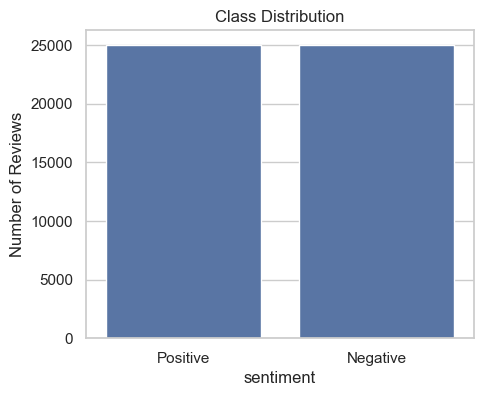

sentiment
1    25000
0    25000
Name: count, dtype: int64

In [32]:
# Class distribution
class_counts = df['sentiment'].value_counts()

plt.figure(figsize=(5,4))
sns.barplot(x=class_counts.index.map({1:"Positive",0:"Negative"}), y=class_counts.values)
plt.title("Class Distribution")
plt.ylabel("Number of Reviews")
plt.show()

class_counts


In [5]:
# word count per review
df['word_count'] = df['clean_review'].apply(lambda x: len(x.split()))

stats = df.groupby('sentiment')['word_count'].agg(['mean', 'median', 'std'])
stats.rename(index={1:'Positive',0:'Negative'})


,mean,median,std
sentiment,,,
Negative,227.11432,172.0,163.185663
Positive,230.62320,171.0,175.751225


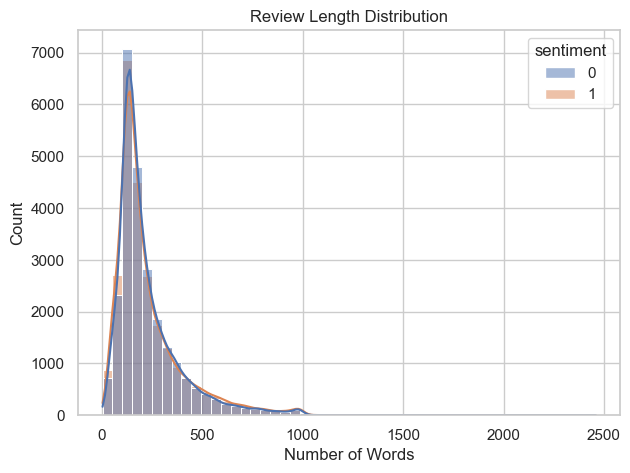

In [6]:
# Visualization of word count distribution per review and class
plt.figure(figsize=(7,5))
sns.histplot(data=df, x='word_count', hue='sentiment', bins=50, kde=True)
plt.title("Review Length Distribution")
plt.xlabel("Number of Words")
plt.show()


In [35]:
# Top content words per class (not needed)
stop_words = set(stopwords.words("english"))

def top_content_words(texts, n=20):
    c = Counter()
    for doc in texts:
        for w in doc.split():
            if w.isalpha() and w not in stop_words:
                c[w] += 1
    return pd.DataFrame(c.most_common(n), columns=["word", "count"])

top_pos_content = top_content_words(df[df.sentiment==1]["clean_review"], n=20)
top_neg_content = top_content_words(df[df.sentiment==0]["clean_review"], n=20)

display(top_pos_content)
display(top_neg_content)


,word,count
0,film,29392
1,movie,26710
2,one,23685
3,like,16441
4,good,11872
5,great,11234
6,see,11097
7,really,10351
8,would,10301
9,also,9788


,word,count
0,movie,34844
1,film,25744
2,one,22056
3,like,21032
4,even,14796
5,would,13537
6,good,11704
7,really,11493
8,bad,10676
9,see,9909


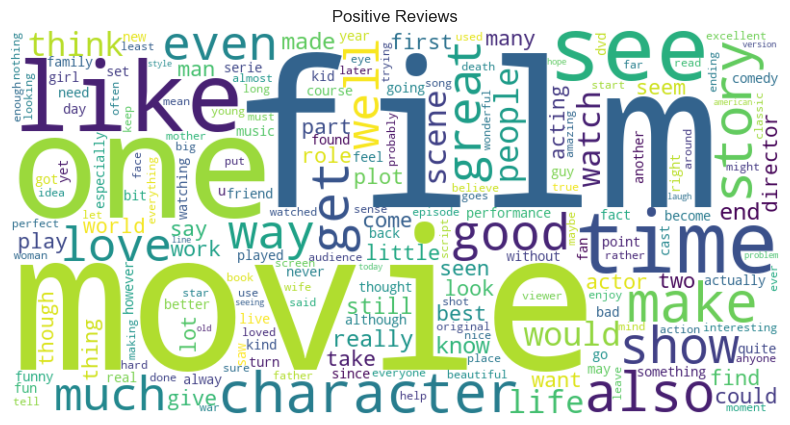

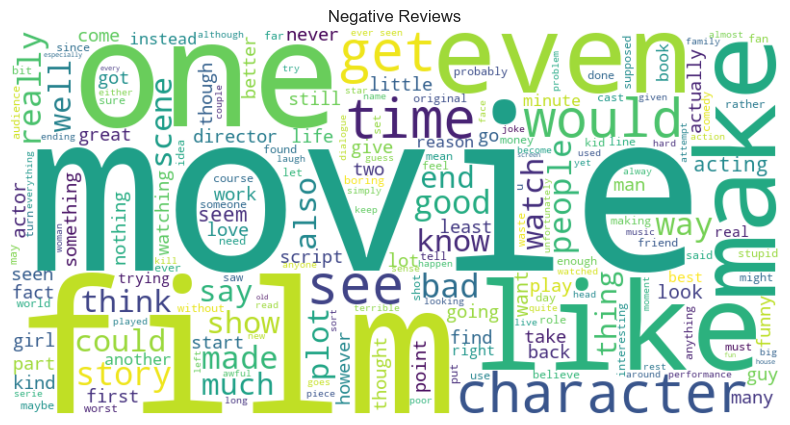

In [36]:
# Word Clouds per class
stop_words = set(stopwords.words('english'))

def plot_wordcloud(text, title):
    wc = WordCloud(
        width=800, height=400,
        stopwords=stop_words,
        background_color="white"
    ).generate(text)

    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)
    plt.show()

plot_wordcloud(" ".join(df[df.sentiment==1]['clean_review']), "Positive Reviews")
plot_wordcloud(" ".join(df[df.sentiment==0]['clean_review']), "Negative Reviews")


In [ ]:

# Top bigrams overall TODO: no stopwords
bigram_vec = CountVectorizer(ngram_range=(2,2), min_df=20)
X2 = bigram_vec.fit_transform(df["clean_review"])
bigrams = bigram_vec.get_feature_names_out()
bigram_counts = np.asarray(X2.sum(axis=0)).ravel()

bigram_df = (pd.DataFrame({"ngram": bigrams, "count": bigram_counts})
               .sort_values("count", ascending=False))

# Top bigrams overall (keep this)
display(bigram_df.head(20))

,ngram,count
33535,of the,77292
23037,in the,50281
49279,this movie,31541
45789,the film,26856
4007,and the,26715
46566,the movie,23896
51008,to the,23739
50148,to be,23492
49162,this film,21820
24966,it is,19918


In [38]:
# Vocabulary size and coverage analysis
all_words = " ".join(df['clean_review']).split()
word_counts = Counter(all_words)

total_tokens = sum(word_counts.values())
coverage = []

for k in [1000, 5000, 10000, 20000]:
    top_k = sum([count for _, count in word_counts.most_common(k)])
    coverage.append((k, top_k / total_tokens))

coverage_df = pd.DataFrame(coverage, columns=['Top-K Words', 'Token Coverage'])
coverage_df


,Top-K Words,Token Coverage
0,1000,0.703469
1,5000,0.834321
2,10000,0.880012
3,20000,0.917503


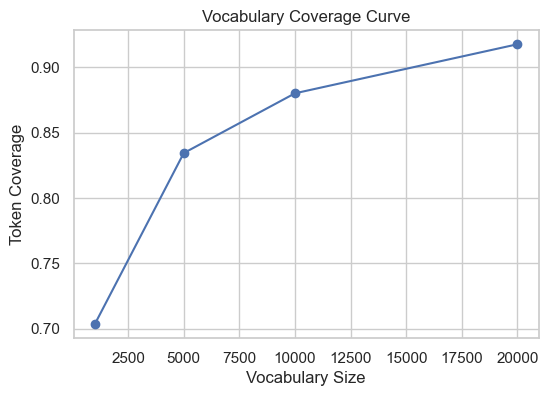

In [39]:
plt.figure(figsize=(6,4))
plt.plot(coverage_df['Top-K Words'], coverage_df['Token Coverage'], marker='o')
plt.title("Vocabulary Coverage Curve")
plt.ylabel("Token Coverage")
plt.xlabel("Vocabulary Size")
plt.show()


In [ ]:
# Most Discriminative Words (Log-Odds Approximation)

vectorizer = CountVectorizer(
    min_df=50,
    token_pattern=r'(?u)\b[a-z][a-z]+\b'
)
X = vectorizer.fit_transform(df["clean_review"])
vocab = vectorizer.get_feature_names_out()

pos_mask = (df["sentiment"] == 1).to_numpy()
neg_mask = (df["sentiment"] == 0).to_numpy()

pos_counts = X[pos_mask].sum(axis=0).A1
neg_counts = X[neg_mask].sum(axis=0).A1

log_odds = np.log((pos_counts + 1) / (neg_counts + 1))
log_odds_df = pd.DataFrame({"word": vocab, "log_odds": log_odds})

top_positive = log_odds_df.sort_values("log_odds", ascending=False).head(20)
top_negative = log_odds_df.sort_values("log_odds", ascending=True).head(20)

display(top_positive)
display(top_negative)


,word,log_odds
2816,edie,3.004031
3340,felix,2.873565
5507,matthau,2.856470
2851,eisenstein,2.790288
3102,excellently,2.740840
7078,raoul,2.533697
3282,farley,2.505526
2431,devito,2.468100
5711,miyazaki,2.380703
4000,haines,2.311635


,word,log_odds
9511,uwe,-4.356709
955,boll,-4.257974
5425,manos,-4.158883
8532,stinker,-2.963397
3561,forwarding,-2.961831
9304,turd,-2.736221
8495,steaming,-2.708050
8627,stunk,-2.691243
9724,waste,-2.680486
12,abomination,-2.614960


In [41]:
negations = {
    "not", "no", "never", 
    "don't", "dont", "didn't","didnt", "isn't", "isnt", "wasn't", "wasnt",
    "can't", "cant", "won't", "wont", "couldn't", "couldnt", "shouldn't", "shouldnt"
}

df['negation_count'] = df['clean_review'].apply(
    lambda x: sum(word in negations for word in x.split())
)

df.groupby('sentiment')['negation_count'].mean().rename(index={1:'Positive',0:'Negative'})


sentiment
Negative    3.21676
Positive    2.41776
Name: negation_count, dtype: float64

In [42]:
df['stopword_ratio'] = df['clean_review'].apply(
    lambda x: np.mean([word in stop_words for word in x.split()])
)

df.groupby('sentiment')['stopword_ratio'].mean().rename(index={1:'Positive',0:'Negative'})


sentiment
Negative    0.464169
Positive    0.461148
Name: stopword_ratio, dtype: float64